In [53]:
import numpy as np
import os
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import itertools
import math
from tqdm import tqdm
import csv
import pickle
import random
import time
import re

from IPython.display import Audio, display
import matplotlib.pyplot as plt

from RSA_helpers import *


device = ("mps" if torch.backends.mps.is_available() else "cpu")
print("using device:", device)
torch.set_default_dtype(torch.float)

using device: mps


## Fetch data

In [2]:
S_features = torch.load('../data/FSD50/eval_audio_features.pt', weights_only=True)

U_features = torch.load('../data/vocal_synth/U_features_raw.pt', weights_only=True)
U_features = torch.nn.functional.normalize(U_features, dim=-1)

## Plot referent/utterance embeddings

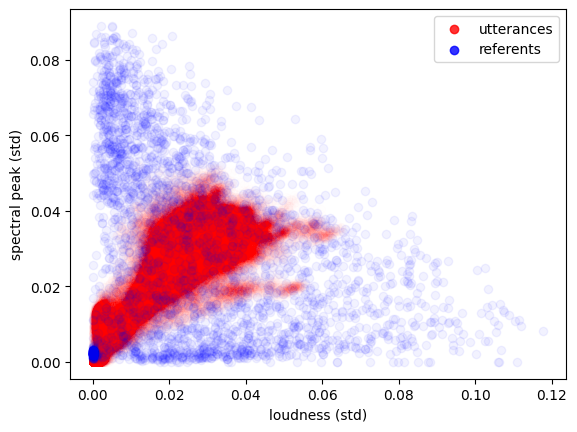

In [4]:
u = np.clip(torch.mean(U_features.reshape(11**5, 836).reshape(11**5, 19, 44), dim=2) + torch.randn(161051, 19)*0.0005, a_min=0, a_max=1)
s = torch.mean(S_features.reshape(3000, 19, 44), dim=2)

F_1 = 0
F_2 = 16

u_x = [x[F_1] for x in u]
u_y = [x[F_2] for x in u]

s_x = [x[F_1] for x in s]
s_y = [x[F_2] for x in s]


plt.scatter(u_x, u_y, c='red', alpha=0.002, label='utterances')
plt.scatter(s_x, s_y, c='blue', alpha=0.05, label='referents')

plt.xlabel('loudness (std)')
plt.ylabel('spectral peak (std)')

leg = plt.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)

## Analyze vocal imitations

In [5]:
feature_extractor = SimpleAudioFeatures()

In [6]:
VI_DIR = '../data/vocal_imitations/'
FEAT_LEN = 44

all_vi = [d for d in os.listdir(VI_DIR) if (os.path.isfile(os.path.join(VI_DIR, d)) and d[-4:]=='.wav')]

def extract_all_vi_features():
    resampler = T.Resample(20_000, AUDIO_SR)
    features = torch.zeros((len(all_vi),) + (FEAT_LEN*N_AUDIO_FEATURES,))
    NOISE_EPS = 1e-15
    
    for i, sample in tqdm(enumerate(all_vi), total=len(all_vi)):
        sample_audio, sr = torchaudio.load(VI_DIR + sample)
        sample_audio = sample_audio.repeat((1,5))      # COPY TO BE >= REF - FOR ONESHOTS
        resampled = resampler(sample_audio[0,:])[:AUDIO_SR*SAMPLE_LEN//CONTROL_SR]

        # add tiny noise since zeros give log NaNs for derivatives
        noised = resampled + torch.randn(AUDIO_SR*SAMPLE_LEN//CONTROL_SR)*NOISE_EPS
        f = feature_extractor(noised)
        feature_vector = torch.reshape(f, (-1,))
        features[i,:] = feature_vector
    
    features = torch.nn.functional.normalize(features, dim=-1)
    torch.save(features, '../data/vocal_imitations/vi_audio_features.pt')

# extract_all_vi_features()

vi_features = torch.load('../data/vocal_imitations/vi_audio_features.pt')

In [7]:
vi_features.shape

torch.Size([5601, 836])

## Plot synth utterances vs. human utterances

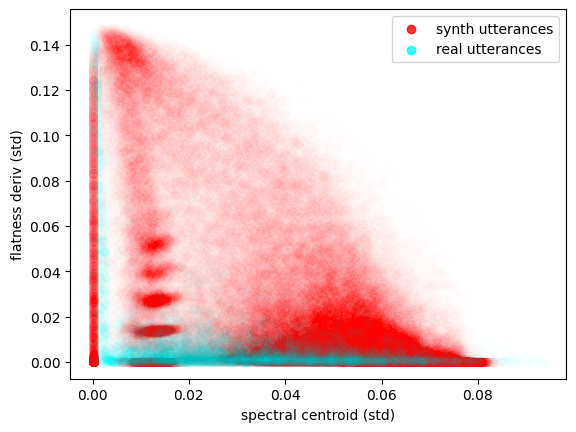

In [8]:
u = np.clip(torch.mean(U_features.reshape(11**5, 836).reshape(11**5, 19, 44), dim=2), a_min=0, a_max=1)
i = torch.mean(vi_features.reshape(5601, 19, 44), dim=2)

F_1 = 15
F_2 = 7

u_x = [x[F_1] for x in u]
u_y = [x[F_2] for x in u]

i_x = [x[F_1] for x in i]
i_y = [x[F_2] for x in i]


plt.scatter(u_x, u_y, c='red', alpha=0.002, label='synth utterances')
plt.scatter(i_x, i_y, c='cyan', alpha=0.016, label='real utterances')

plt.xlabel('spectral centroid (std)')
plt.ylabel('flatness deriv (std)')

leg = plt.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)

## Take a vocal imitation and find nearest neighbor

In [24]:
VI_TO_CAT_PATH = '../data/vocal_imitations/categories.csv'

def find_all_vi_categories():
    vi_to_category = {}

    # find categories
    with open(VI_TO_CAT_PATH, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader, None)  # skip header
        for row in reader:
            vi = row[1]
            cat = [x for x in row[3:9] if x][-1]
            vi_to_category[vi] = cat

    return vi_to_category

vi_to_category = find_all_vi_categories()


# from RSA run
ref_to_ut = np.load("../data/pickles/ref_ut_mapping.npy")

mapped_utterances = set([x[1] for x in ref_to_ut])
ut_to_ref = {row[1]:row[0] for row in ref_to_ut}

In [39]:
ont_tree = build_ontology_tree()

In [138]:
VI_I = 20
vi_path = all_vi[VI_I]

vi_features[VI_I].unsqueeze(1).shape

synth_utterance_sim = U_features.reshape(11**5, 836) @ vi_features[VI_I]
synth_utterance_sim = torch.nan_to_num(synth_utterance_sim.reshape(11,11,11,11,11))

top_similarities, top_synth_utterances = torch.topk(synth_utterance_sim.flatten(), 110000)
top_synth_utterances_locs = [torch.unravel_index(x, synth_utterance_sim.shape) for x in top_synth_utterances]
top_synth_utterances_paths = ['-'.join([str(int(ix.detach())) for ix in utterance]) for utterance in top_synth_utterances_locs]

top_mapped_utterances = [u for u in top_synth_utterances_paths if u in mapped_utterances]

print("intended referent:", vi_path)
# print("top synth matches:", top_mapped_utterances)

top_referents = [ut_to_ref[u] for u in top_mapped_utterances]
print("top referents (unconstrained) ", top_referents)

intended referent: 051Human sounds_Human voice_Crying_ sobbing_Baby cry_ infant cry-5953092570841088.wav
top referents (unconstrained)  ['Motorcycle', 'Motor_vehicle_(road)', 'Train', 'Cricket', 'Ratchet_and_pawl', 'Crying_and_sobbing', 'Car', 'Chink_and_clink', 'Hiss', 'Bass_guitar', 'Writing', 'Writing', 'Gunshot_and_gunfire', 'Accordion', 'Buzz', 'Scratching_(performance_technique)', 'Purr', 'Hammer', 'Water_tap_and_faucet', 'Tabla', 'Drip', 'Mechanisms', 'Keys_jangling', 'Ringtone', 'Tearing', 'Tap']


### Marginal probabilities of subtrees

In [ ]:
cat_counts = {}
TREE_LEVEL = 1

for i, ref in enumerate(top_referents):
    cat = find_key(ont_tree, ref)[TREE_LEVEL]
    if cat in marginal_probs:
        marginal_probs[cat] += 1
    else:
        marginal_probs[cat] = 1

marginal_probs

In [139]:
marginal_probs = {}
TREE_LEVEL = 1

for i, ref in enumerate(top_referents):
    cat = find_key(ont_tree, ref)[TREE_LEVEL]
    if cat in marginal_probs:
        marginal_probs[cat] += float(top_similarities[i])
    else:
        marginal_probs[cat] = float(top_similarities[i])

sum_probs = sum(marginal_probs.values())
marginal_probs = {k : v/sum_probs for k,v in marginal_probs.items()}
marginal_probs

{'/t/dd00041': 0.6154767590741346,
 '/m/0jbk': 0.15391787386263253,
 '/m/0dgw9r': 0.038529797895049706,
 '/m/04rlf': 0.15372859310669792,
 '/t/dd00098': 0.03834697606148524}